In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from haversine import haversine
from math import sin, cos, sqrt, atan2, radians

In [2]:
data = pd.read_excel('대안3 위경도.xlsx')
data

,위치,위도,경도
0,"(37.5099195, 127.0189443)",37.509920,127.018944
1,"(37.50500645, 127.0042355)",37.505006,127.004235
2,"(37.49223635, 127.0259132)",37.492236,127.025913
3,"(37.4918948, 126.990054)",37.491895,126.990054
4,"(37.48484455, 127.0178303)",37.484845,127.017830
...,...,...,...
70,"(37.49390135, 127.0152335)",37.493901,127.015233
71,"(37.4833784, 127.0355331)",37.483378,127.035533
72,"(37.49417187, 127.0137374)",37.494172,127.013737
73,"(37.48200504, 127.0018917)",37.482005,127.001892


In [3]:
# Clustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn_extra.cluster import KMedoids

#Scaling
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_samples, silhouette_score,davies_bouldin_score

In [4]:
# scaling 함수
def df_scaler(data, cols, scale):
    df_cp = data.copy()
    
    if scale == "minmax":
        X = df_cp.loc[:,cols]
        MinMaxScalers = MinMaxScaler()
        MinMaxScalers.fit(X)
        df_MinMaxScaler = MinMaxScalers.transform(X)
        df_cp.loc[:, cols] = df_MinMaxScaler
    elif scale == "standard" :
        X = df_cp.loc[:,cols]
        StandardScalers = StandardScaler()
        StandardScalers.fit(X)
        df_StandardScalers = StandardScalers.transform(X)
        df_cp.loc[:, cols] = df_StandardScalers
    elif scale == "robust" :
        X = df_cp.loc[:,cols]
        RobustScalers = RobustScaler()
        RobustScalers.fit(X)
        df_RobustScaler = RobustScalers.transform(X)
        df_cp.loc[:, cols] = df_RobustScaler
    else:
        print("wrong")
    return df_cp

C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

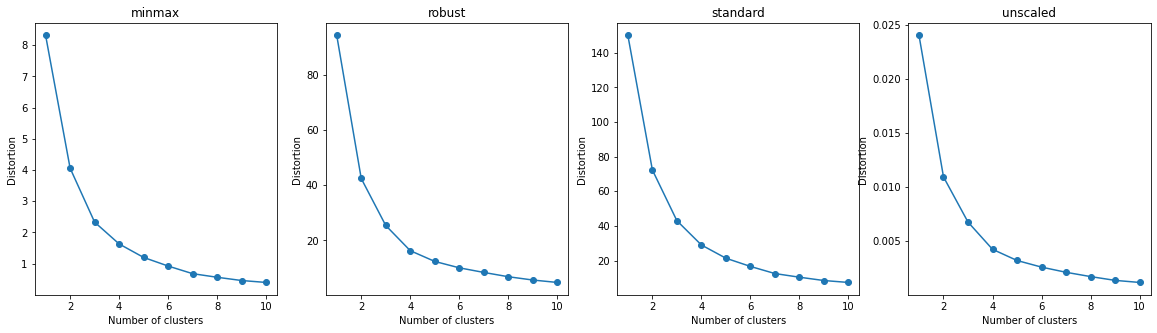

In [5]:
df = data.copy()
cols = ['위도','경도']
cols_ = ['위도','경도']
scaler = ['minmax', 'robust', 'standard', 'unscaled']
box = {}

for m in scaler:
    if m == 'unscaled':
        box[m] = df.loc[:,cols]
    else:
        box[m] = df_scaler(df, cols_, scale = m)


n = len(box)
fig, axes = plt.subplots(1,n,figsize = (5 * n, 5))
for i in range(len(scaler)):
    distortions = []
    for j in range(1, 11):
        km = KMeans(n_clusters=j)
        km.fit(box[scaler[i]].loc[:,cols])
        distortions.append(km.inertia_) # 군집 내 분산, 적을수록 좋음
    
    axes[i].plot(range(1, 11), distortions, marker='o')
    axes[i].set_title(scaler[i])
    axes[i].set_xlabel('Number of clusters')
    axes[i].set_ylabel('Distortion')
plt.show()

C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0, flags=flags)


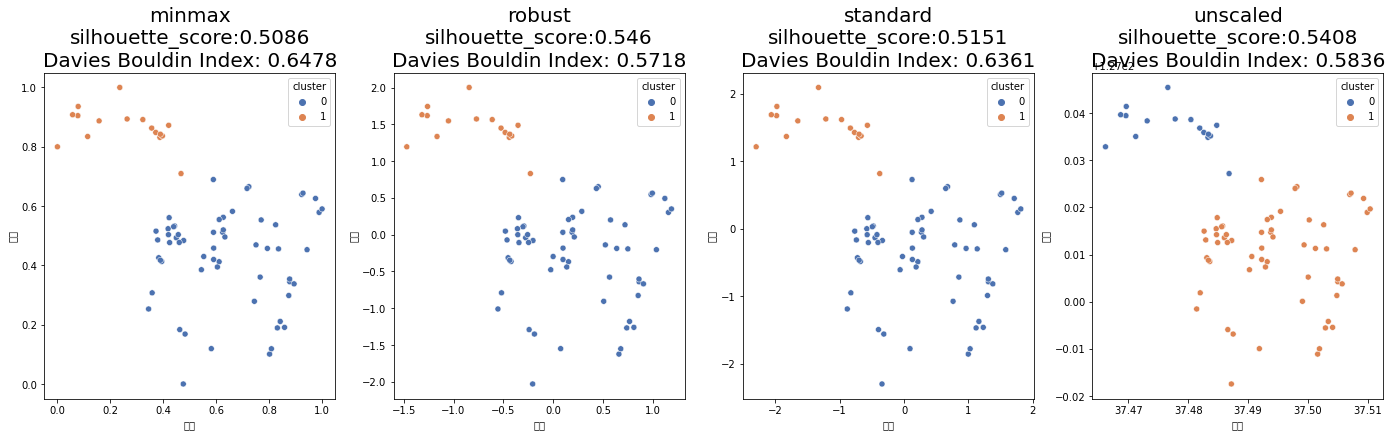

In [6]:
n = len(box)
fig, axes = plt.subplots(1,n,figsize = (6 * n, 6))
for i in range(len(scaler)):
    
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(box[scaler[i]].loc[:,cols])
    box[scaler[i]]['cluster'] = kmeans.labels_
    
    s = sns.scatterplot(x = cols[0], y = cols[1], data = box[scaler[i]], marker='o', hue = 'cluster', palette = 'deep', ax = axes[i])
    s.set_title(f"{scaler[i]}\nsilhouette_score:{round(silhouette_score(box[scaler[i]].loc[:,cols], kmeans.labels_),4)}\nDavies Bouldin Index: {round(davies_bouldin_score(box[scaler[i]].loc[:,cols],kmeans.labels_),4)}", fontsize = 20)

    #s.set_xlabel(cols[0])
    #s.set_ylabel(cols[1])
plt.show()

C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


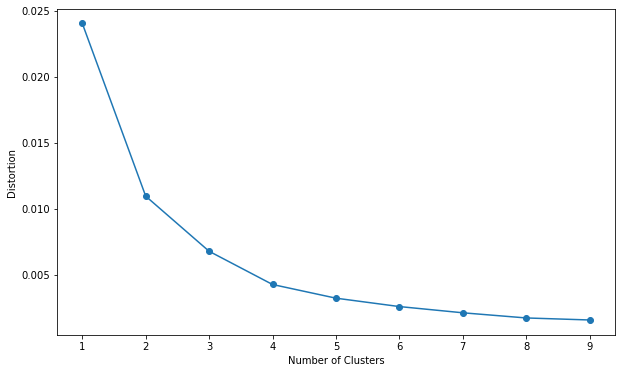

In [7]:
data_elbow = data.drop(['위치'], axis = 1)

distortions = []
for i in range(1,10):
    km = KMeans(
    n_clusters= i, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
    )
    km.fit(data_elbow)
    distortions.append(km.inertia_)
plt.figure(figsize=(10,6))
plt.plot(range(1,10), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [8]:
# k-means clustering

data1 = data_elbow.copy()
model1 = KMeans(n_clusters=2, random_state=2021009, algorithm='auto')
model1.fit(data1)

KMeans(n_clusters=2, random_state=2021009)

In [9]:
# 각 군집(cluster) 표시
pred1 = model1.predict(data1)
pred1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0])

In [10]:
# 원형 데이터에 군집 예측치 추가
data['k_means_cluster'] = pred1
data

,위치,위도,경도,k_means_cluster
0,"(37.5099195, 127.0189443)",37.509920,127.018944,1
1,"(37.50500645, 127.0042355)",37.505006,127.004235,1
2,"(37.49223635, 127.0259132)",37.492236,127.025913,1
3,"(37.4918948, 126.990054)",37.491895,126.990054,1
4,"(37.48484455, 127.0178303)",37.484845,127.017830,1
...,...,...,...,...
70,"(37.49390135, 127.0152335)",37.493901,127.015233,1
71,"(37.4833784, 127.0355331)",37.483378,127.035533,0
72,"(37.49417187, 127.0137374)",37.494172,127.013737,1
73,"(37.48200504, 127.0018917)",37.482005,127.001892,1


In [11]:
# 군집별 통계(평균)
cluster_k1 = data.groupby('k_means_cluster')
cluster_k1.mean()

,위도,경도
k_means_cluster,,
0,37.477491,127.037031
1,37.494541,127.009646


In [12]:
# 군집별 통계(중앙값)
cluster_k1 = data.groupby('k_means_cluster')
cluster_k1.median()

,위도,경도
k_means_cluster,,
0,37.479134,127.037123
1,37.493217,127.012058


In [13]:
# pd.set_option("display.max_rows", None)

analysis1 = data.copy()
analysis1 = analysis1.sort_values(by='k_means_cluster')
analysis1

,위치,위도,경도,k_means_cluster
74,"(37.473135, 127.038353)",37.473135,127.038353,0
44,"(37.4832966, 127.0348614)",37.483297,127.034861,0
32,"(37.486832, 127.0271812)",37.486832,127.027181,0
46,"(37.481927, 127.036827)",37.481927,127.036827,0
47,"(37.46958572, 127.0394643)",37.469586,127.039464,0
...,...,...,...,...
23,"(37.482653, 127.0149731)",37.482653,127.014973,1
22,"(37.5012701, 127.0113085)",37.501270,127.011308,1
21,"(37.4922607, 127.0147246)",37.492261,127.014725,1
29,"(37.4990959, 127.0000948)",37.499096,127.000095,1


In [14]:
is_0 = data['k_means_cluster'] == 0
is_1 = data['k_means_cluster'] == 1

In [15]:
print(len(data[is_0]))
data[is_0]

16


,위치,위도,경도,k_means_cluster
10,"(37.46616915, 127.0328588)",37.466169,127.032859,0
19,"(37.471225, 127.035042)",37.471225,127.035042,0
24,"(37.4696368, 127.0414121)",37.469637,127.041412,0
25,"(37.4804501, 127.0386293)",37.480450,127.038629,0
32,"(37.486832, 127.0271812)",37.486832,127.027181,0
44,"(37.4832966, 127.0348614)",37.483297,127.034861,0
46,"(37.481927, 127.036827)",37.481927,127.036827,0
47,"(37.46958572, 127.0394643)",37.469586,127.039464,0
48,"(37.48372183, 127.035159)",37.483722,127.035159,0
49,"(37.48261, 127.035902)",37.482610,127.035902,0


In [16]:
print(len(data[is_1]))
data[is_1]

59


,위치,위도,경도,k_means_cluster
0,"(37.5099195, 127.0189443)",37.509920,127.018944,1
1,"(37.50500645, 127.0042355)",37.505006,127.004235,1
2,"(37.49223635, 127.0259132)",37.492236,127.025913,1
3,"(37.4918948, 126.990054)",37.491895,126.990054,1
4,"(37.48484455, 127.0178303)",37.484845,127.017830,1
5,"(37.5002327, 127.0173489)",37.500233,127.017349,1
6,"(37.5031307, 127.0112106)",37.503131,127.011211,1
7,"(37.5041415, 126.9945667)",37.504142,126.994567,1
8,"(37.4938982, 127.0179032)",37.493898,127.017903,1
9,"(37.4902382, 127.0067846)",37.490238,127.006785,1


In [17]:
# cluster = 0
cluster0 = data.copy()
cluster0 = cluster0[is_0]
cluster0 = cluster0[['위치','위도','경도']]
cluster0.reset_index(drop = True,inplace = True)
cluster0

,위치,위도,경도
0,"(37.46616915, 127.0328588)",37.466169,127.032859
1,"(37.471225, 127.035042)",37.471225,127.035042
2,"(37.4696368, 127.0414121)",37.469637,127.041412
3,"(37.4804501, 127.0386293)",37.480450,127.038629
4,"(37.486832, 127.0271812)",37.486832,127.027181
5,"(37.4832966, 127.0348614)",37.483297,127.034861
6,"(37.481927, 127.036827)",37.481927,127.036827
7,"(37.46958572, 127.0394643)",37.469586,127.039464
8,"(37.48372183, 127.035159)",37.483722,127.035159
9,"(37.48261, 127.035902)",37.482610,127.035902


In [18]:
# cluster = 1
cluster1 = data.copy()
cluster1 = cluster1[is_1]
cluster1 = cluster1[['위치','위도','경도']]
cluster1.reset_index(drop = True,inplace = True)
cluster1

,위치,위도,경도
0,"(37.5099195, 127.0189443)",37.509920,127.018944
1,"(37.50500645, 127.0042355)",37.505006,127.004235
2,"(37.49223635, 127.0259132)",37.492236,127.025913
3,"(37.4918948, 126.990054)",37.491895,126.990054
4,"(37.48484455, 127.0178303)",37.484845,127.017830
5,"(37.5002327, 127.0173489)",37.500233,127.017349
6,"(37.5031307, 127.0112106)",37.503131,127.011211
7,"(37.5041415, 126.9945667)",37.504142,126.994567
8,"(37.4938982, 127.0179032)",37.493898,127.017903
9,"(37.4902382, 127.0067846)",37.490238,127.006785


In [19]:
washing_herb = cluster_k1.mean()
washing_herb.insert(0,"위치",['(37.477491, 127.037031)','(37.494541, 127.009646)'],True)
washing_herb

,위치,위도,경도
k_means_cluster,,,
0,"(37.477491, 127.037031)",37.477491,127.037031
1,"(37.494541, 127.009646)",37.494541,127.009646


In [20]:
# 전체 합치기

cluster0 = data.copy()
cluster0 = cluster0[is_0]
cluster0 = cluster0[['위치','위도','경도']]
cluster0.reset_index(drop = True,inplace = True)

cluster1 = data.copy()
cluster1 = cluster1[is_1]
cluster1 = cluster1[['위치','위도','경도']]
cluster1.reset_index(drop = True,inplace = True)

lat = data['위도'].mean()
long = data['경도'].mean()
map = folium.Map([lat,long],zoom_start = 12)

# 클러스터 0
coords0 = []

for i in range(len(cluster0)):
  x = cluster0['위도'][i]
  y = cluster0['경도'][i]
  coords0.append([x,y])

for j in range(len(coords0)):
  folium.Marker(location = coords0[j], icon = folium.Icon(color='red',icon = 'train',prefix='fa'), popup = cluster0['위치'][j],).add_to(map)

# 클러스터 1
coords1 = []

for i in range(len(cluster1)):
  x = cluster1['위도'][i]
  y = cluster1['경도'][i]
  coords1.append([x,y])

for j in range(len(coords1)):
  folium.Marker(location = coords1[j], icon = folium.Icon(color='blue',icon = 'train',prefix='fa'), popup = cluster1['위치'][j],).add_to(map)

# 세척 허브
coords = []

for i in range(len(washing_herb)):
  x = washing_herb['위도'][i]
  y = washing_herb['경도'][i]
  coords.append([x,y])

for j in range(len(coords)):
  folium.Marker(location = coords[j], icon = folium.Icon(color='purple',icon_color='white',icon='glyphicon glyphicon-thumbs-up', prefix='glyphicon'),popup = washing_herb['위치'][j],).add_to(map)

map.save('대안3 세척허브.html')
map